## Import Modules and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from dateutil.relativedelta import relativedelta
from datetime import date   
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/dp846/OneDrive/Documents/bank_transactions.csv")

## Exploratory Data Analysis

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [6]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [7]:
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,1041614.0,114998.605283,846760.940316,0.0,4728.14,16768.52,57428.85,1.150355e+08
TransactionTime,1041614.0,157122.116378,51263.516076,0.0,124041.00,164247.00,200022.00,2.359590e+05
TransactionAmount (INR),1041614.0,1566.096079,6561.464373,0.0,160.00,457.50,1200.00,1.560035e+06


In [9]:
df['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [10]:
df.loc[df['CustGender'] == 'T']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
953529,T959988,C3380368,1/1/1800,T,CHENNAI,50050.0,10/9/16,170731,32500.0


In [11]:
df[df['CustGender'] == 'T'].index

Int64Index([953529], dtype='int64')

In [12]:
df.drop(df[df['CustGender'] == 'T'].index, inplace = True)
df.reset_index(drop=True, inplace=True)

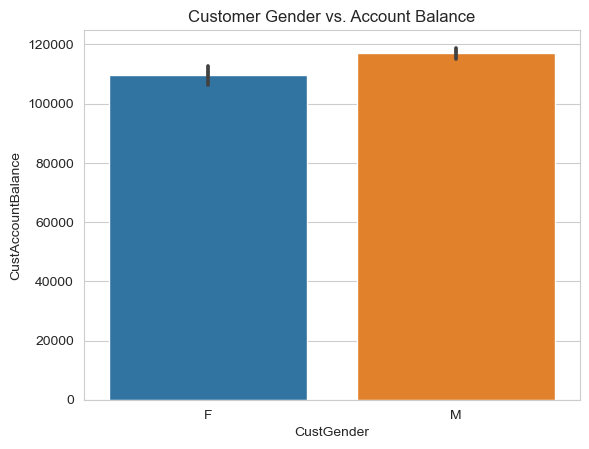

In [13]:
sns.barplot(data=df,x='CustGender',y='CustAccountBalance').set(title='Customer Gender vs. Account Balance');

In [14]:
df = pd.get_dummies(df,columns=['CustGender'],drop_first=True)

In [15]:
date_of_birth = {'customer_dob':[str(i).split('/') for i in df['CustomerDOB']]}
DOB = pd.DataFrame(date_of_birth)
DOB

,customer_dob
0,"[10, 1, 94]"
1,"[4, 4, 57]"
2,"[26, 11, 96]"
3,"[14, 9, 73]"
4,"[24, 3, 88]"
...,...
1041608,"[8, 4, 90]"
1041609,"[20, 2, 92]"
1041610,"[18, 5, 89]"
1041611,"[30, 8, 78]"


In [16]:
day_of_birth = {'customer_day_birth':[DOB.iloc[i]['customer_dob'][0] for i in tqdm(range(len(DOB)))]}
birth_day = pd.DataFrame(day_of_birth)

month_of_birth = {'customer_month_birth':[DOB.iloc[i]['customer_dob'][1] for i in tqdm(range(len(DOB)))]}
birth_month = pd.DataFrame(month_of_birth)

year_of_birth = {'customer_year_birth':[DOB.iloc[i]['customer_dob'][2] for i in tqdm(range(len(DOB)))]}
birth_year = pd.DataFrame(year_of_birth)

100%|██████████| 1041613/1041613 [00:57<00:00, 18212.99it/s]


In [17]:
birth_year['customer_year_birth'].unique()

array(['94', '57', '96', '73', '88', '72', '92', '82', '84', '78', '68',
       '1800', '89', '91', '85', '93', '86', '67', '79', '77', '97', '83',
       '90', '80', '81', '66', '87', '75', '95', '74', '71', '32', '59',
       '99', '65', '41', '54', '70', '76', '21', '69', '04', '43', '98',
       '51', '60', '56', '53', '47', '00', '64', '48', '62', '52', '55',
       '61', '36', '63', '42', '44', '38', '49', '58', '50', '46', '02',
       '45', '37', '07', '01', '39', '40', '13', '03', '05', '10', '11',
       '33', '34', '27', '19', '28', '30', '09', '31', '29', '35', '15',
       '16', '06', '08', '12', '23', '26', '24', '22', '14', '20', '25',
       '18'], dtype=object)

In [18]:
birth_year[birth_year['customer_year_birth']=='1800']

,customer_year_birth
16,1800
22,1800
28,1800
34,1800
150,1800
...,...
1041490,1800
1041499,1800
1041577,1800
1041579,1800


In [19]:
df['CustBirthDay'] = birth_day
df['CustBirthMonth'] = birth_month
df['CustBirthYear'] = birth_year

In [20]:
df.drop(df[df['CustBirthYear'] == '1800'].index, inplace = True)
df.reset_index(drop=True, inplace=True)

In [21]:
df['CustBirthYear'] = ['19' + i for i in df['CustBirthYear']]

In [22]:
transaction_date = {'trans_date':[str(i).split('/') for i in df['TransactionDate']]}
TD = pd.DataFrame(transaction_date)
TD

,trans_date
0,"[2, 8, 16]"
1,"[2, 8, 16]"
2,"[2, 8, 16]"
3,"[2, 8, 16]"
4,"[2, 8, 16]"
...,...
985317,"[18, 9, 16]"
985318,"[18, 9, 16]"
985319,"[18, 9, 16]"
985320,"[18, 9, 16]"


In [23]:
day_of_transaction = {'transaction_day':[TD.iloc[i]['trans_date'][0] for i in tqdm(range(len(TD)))]}
trans_day = pd.DataFrame(day_of_transaction)

month_of_transaction = {'transaction_month':[TD.iloc[i]['trans_date'][1] for i in tqdm(range(len(TD)))]}
trans_month = pd.DataFrame(month_of_transaction)

year_of_transaction = {'transaction_year':[TD.iloc[i]['trans_date'][2] for i in tqdm(range(len(TD)))]}
trans_year = pd.DataFrame(year_of_transaction)

100%|██████████| 985322/985322 [00:55<00:00, 17882.76it/s]


In [24]:
trans_year['transaction_year'].unique()

array(['16'], dtype=object)

In [25]:
df['TransactionDay'] = trans_day
df['TransactionMonth'] = trans_month
df['TransactionYear'] = trans_year

In [26]:
df['TransactionYear'] = ['20' + i for i in df['TransactionYear']]

In [27]:
customer_age = []

for i in tqdm(range(len(df['TransactionDate']))):
    birthday = date(int(df['CustBirthYear'][i]),int(df['CustBirthMonth'][i]),int(df['CustBirthDay'][i]))
    transaction = date(int(df['TransactionYear'][i]),int(df['TransactionMonth'][i]),int(df['TransactionDay'][i]))
    cust_age = relativedelta(transaction, birthday).years
    customer_age.append(cust_age)
    
df['CustAge'] = customer_age

100%|██████████| 985322/985322 [00:51<00:00, 18995.64it/s]


In [28]:
df

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustGender_M,CustBirthDay,CustBirthMonth,CustBirthYear,TransactionDay,TransactionMonth,TransactionYear,CustAge
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0,10,1,1994,2,8,2016,22
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,2/8/16,141858,27999.0,1,4,4,1957,2,8,2016,59
2,T3,C4417068,26/11/96,MUMBAI,17874.44,2/8/16,142712,459.0,0,26,11,1996,2,8,2016,19
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2/8/16,142714,2060.0,0,14,9,1973,2,8,2016,42
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,0,24,3,1988,2,8,2016,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,8/4/90,NEW DELHI,7635.19,18/9/16,184824,799.0,1,8,4,1990,18,9,2016,26
985318,T1048564,C6459278,20/2/92,NASHIK,27311.42,18/9/16,183734,460.0,1,20,2,1992,18,9,2016,24
985319,T1048565,C6412354,18/5/89,HYDERABAD,221757.06,18/9/16,183313,770.0,1,18,5,1989,18,9,2016,27
985320,T1048566,C6420483,30/8/78,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,1,30,8,1978,18,9,2016,38


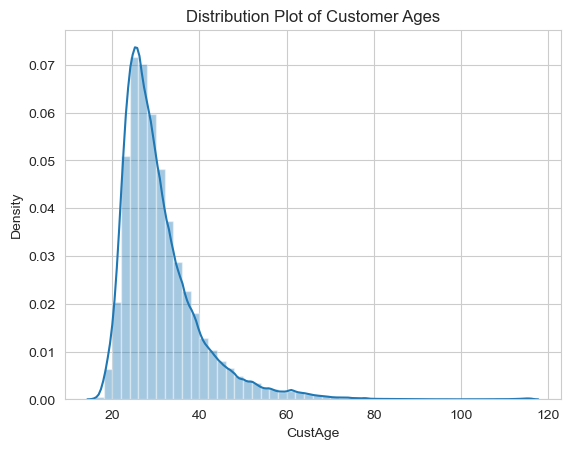

In [29]:
sns.distplot(df['CustAge']).set(title='Distribution Plot of Customer Ages');

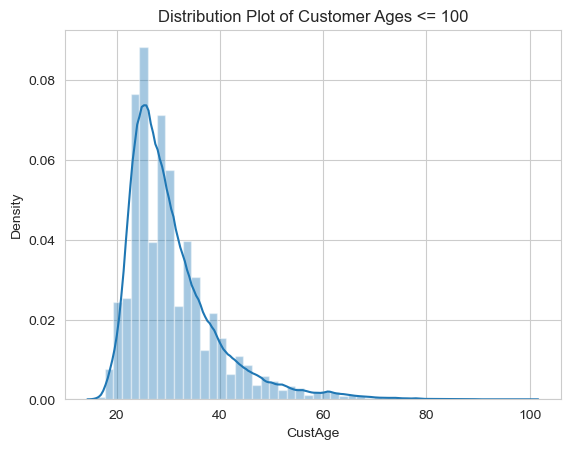

In [30]:
sns.distplot(df[df['CustAge'] <= 100]['CustAge']).set(title='Distribution Plot of Customer Ages <= 100');

In [31]:
df['CustAge'].value_counts()

26     73053
25     72905
24     68397
27     65386
28     61138
       ...  
100        6
92         3
90         2
91         1
98         1
Name: CustAge, Length: 98, dtype: int64

In [32]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustGender_M,CustBirthDay,CustBirthMonth,CustBirthYear,TransactionDay,TransactionMonth,TransactionYear,CustAge
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0,10,1,1994,2,8,2016,22
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,2/8/16,141858,27999.0,1,4,4,1957,2,8,2016,59
2,T3,C4417068,26/11/96,MUMBAI,17874.44,2/8/16,142712,459.0,0,26,11,1996,2,8,2016,19
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2/8/16,142714,2060.0,0,14,9,1973,2,8,2016,42
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,0,24,3,1988,2,8,2016,28


In [33]:
generations = []
for i in df['CustBirthYear']:
    if (int(i) > 2000):
        generation_a = 'After Google'
        generations.append(generation_a)
    elif (int(i) >= 1981 and int(i) <= 2000):
        generation_p = 'Progressives'
        generations.append(generation_p)
    elif (int(i) >= 1961 and int(i) <= 1980):
        generation_c = 'Conventionalists'
        generations.append(generation_c)
    else:
        generation_d = 'Die-hards'
        generations.append(generation_d)

df['CustGeneration'] = generations
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustGender_M,CustBirthDay,CustBirthMonth,CustBirthYear,TransactionDay,TransactionMonth,TransactionYear,CustAge,CustGeneration
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0,10,1,1994,2,8,2016,22,Progressives
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,2/8/16,141858,27999.0,1,4,4,1957,2,8,2016,59,Die-hards
2,T3,C4417068,26/11/96,MUMBAI,17874.44,2/8/16,142712,459.0,0,26,11,1996,2,8,2016,19,Progressives
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2/8/16,142714,2060.0,0,14,9,1973,2,8,2016,42,Conventionalists
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,0,24,3,1988,2,8,2016,28,Progressives


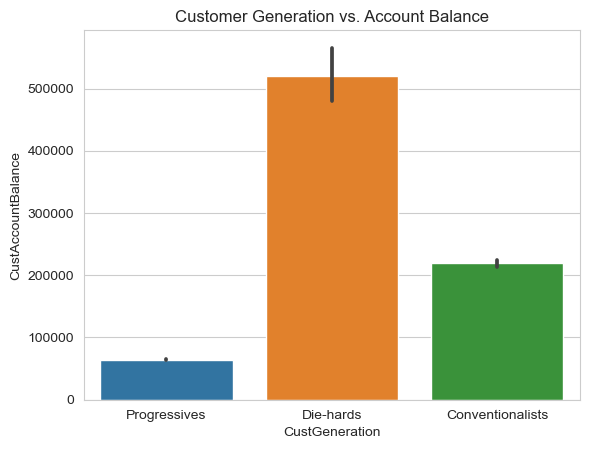

In [34]:
sns.barplot(data=df,x='CustGeneration',y='CustAccountBalance').set(title='Customer Generation vs. Account Balance');

In [35]:
df['TransactionDate'].unique()

array(['2/8/16', '1/8/16', '3/8/16', '5/8/16', '4/8/16', '6/8/16',
       '9/8/16', '8/8/16', '12/8/16', '7/8/16', '21/10/16', '16/10/16',
       '10/8/16', '14/8/16', '17/8/16', '21/8/16', '19/8/16', '24/8/16',
       '22/8/16', '29/8/16', '22/9/16', '23/9/16', '13/8/16', '25/8/16',
       '28/8/16', '15/8/16', '27/8/16', '31/8/16', '20/8/16', '23/8/16',
       '30/8/16', '11/8/16', '16/8/16', '26/8/16', '27/9/16', '18/8/16',
       '25/9/16', '26/9/16', '30/9/16', '3/9/16', '2/9/16', '1/9/16',
       '6/9/16', '5/9/16', '4/9/16', '9/9/16', '8/9/16', '7/9/16',
       '12/9/16', '11/9/16', '10/9/16', '15/9/16', '14/9/16', '13/9/16',
       '18/9/16'], dtype=object)

In [36]:
df.drop(['CustomerDOB', 'TransactionDate'], axis=1,inplace=True)

In [37]:
trans_date = []

for i in tqdm(range(len(df['TransactionID']))):
    t_date = date(int(df['TransactionYear'][i]),int(df['TransactionMonth'][i]),int(df['TransactionDay'][i]))
    trans_date.append(t_date)
    
df['TransactionDate'] = trans_date

100%|██████████| 985322/985322 [00:15<00:00, 64704.28it/s]


In [38]:
df.drop(['CustBirthDay', 'CustBirthMonth','CustBirthYear','TransactionDay','TransactionMonth','TransactionYear','TransactionID'], axis=1,inplace=True)

In [39]:
df

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-hards,2016-08-02
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02
...,...,...,...,...,...,...,...,...,...
985317,C8020229,NEW DELHI,7635.19,184824,799.0,1,26,Progressives,2016-09-18
985318,C6459278,NASHIK,27311.42,183734,460.0,1,24,Progressives,2016-09-18
985319,C6412354,HYDERABAD,221757.06,183313,770.0,1,27,Progressives,2016-09-18
985320,C6420483,VISAKHAPATNAM,10117.87,184706,1000.0,1,38,Conventionalists,2016-09-18


In [40]:
df['Rank'] = df.sort_values(['CustomerID','TransactionDate']).groupby(['CustomerID'])['TransactionDate'].rank(method='min').astype(int)

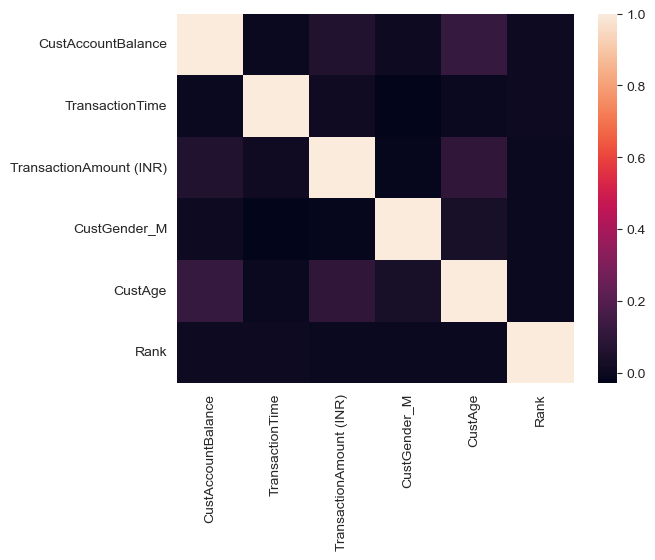

In [41]:
sns.heatmap(df.corr());

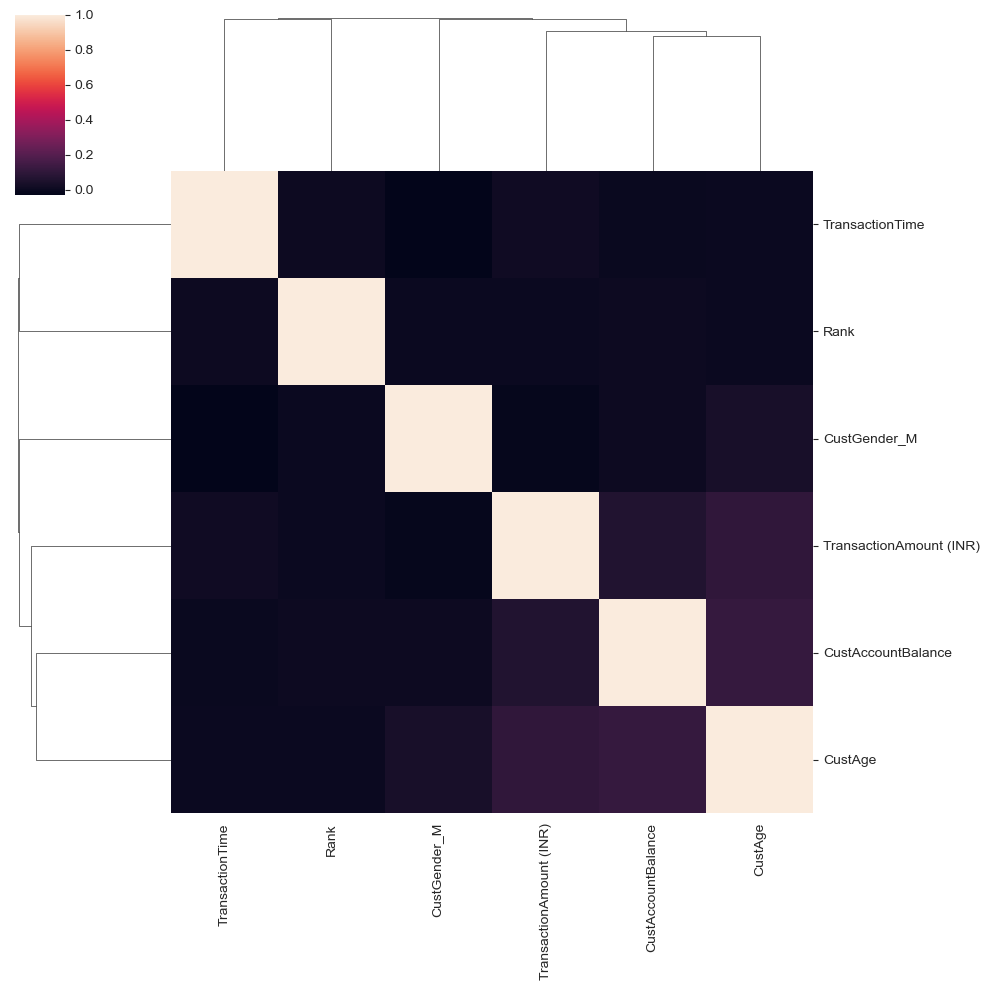

In [42]:
sns.clustermap(df.corr());

## Recency

In [43]:
df_rec = df[df['Rank']==1]
df_rec.reset_index(drop=True, inplace=True)

In [44]:
df_rec

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02,1
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-hards,2016-08-02,1
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02,1
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02,1
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02,1
...,...,...,...,...,...,...,...,...,...,...
841849,C5028150,PUNE,464.87,184632,3000.0,1,36,Conventionalists,2016-09-18,1
841850,C1034220,BANGALORE,1212.70,184734,1500.0,1,23,Progressives,2016-09-18,1
841851,C8020229,NEW DELHI,7635.19,184824,799.0,1,26,Progressives,2016-09-18,1
841852,C6459278,NASHIK,27311.42,183734,460.0,1,24,Progressives,2016-09-18,1


In [45]:
df_rec = df_rec.assign(Recency = (df_rec['TransactionDate'] - min(df_rec['TransactionDate'])))

In [46]:
df_rec['Recency'] = df_rec['Recency'].astype(str).str.replace(' days', '')

In [47]:
df_rec['Recency'] = df_rec['Recency'].astype(int)

In [48]:
df_rec.head()

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank,Recency
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02,1,1
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-hards,2016-08-02,1,1
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02,1,1
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02,1,1
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02,1,1


## Frequency

In [49]:
freq = df_rec.groupby('CustomerID')['TransactionDate'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','Frequency']

In [50]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')

In [51]:
rec_freq.head()

,CustomerID,Frequency,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank,Recency
0,C1010011,1,NEW DELHI,120180.54,11229,356.0,1,33,Progressives,2016-08-09,1,8
1,C1010012,1,MUMBAI,24204.49,204409,1499.0,1,22,Progressives,2016-08-14,1,13
2,C1010014,1,MUMBAI,38377.14,154451,1205.0,0,24,Progressives,2016-08-01,1,0
3,C1010018,1,CHAMPARAN,496.18,170254,30.0,0,26,Progressives,2016-09-15,1,45
4,C1010024,1,KOLKATA,87058.65,141103,5000.0,1,51,Conventionalists,2016-08-18,1,17


## Final Dataframe

In [52]:
finaldf = rec_freq[['CustomerID','Recency','Frequency','TransactionAmount (INR)']]

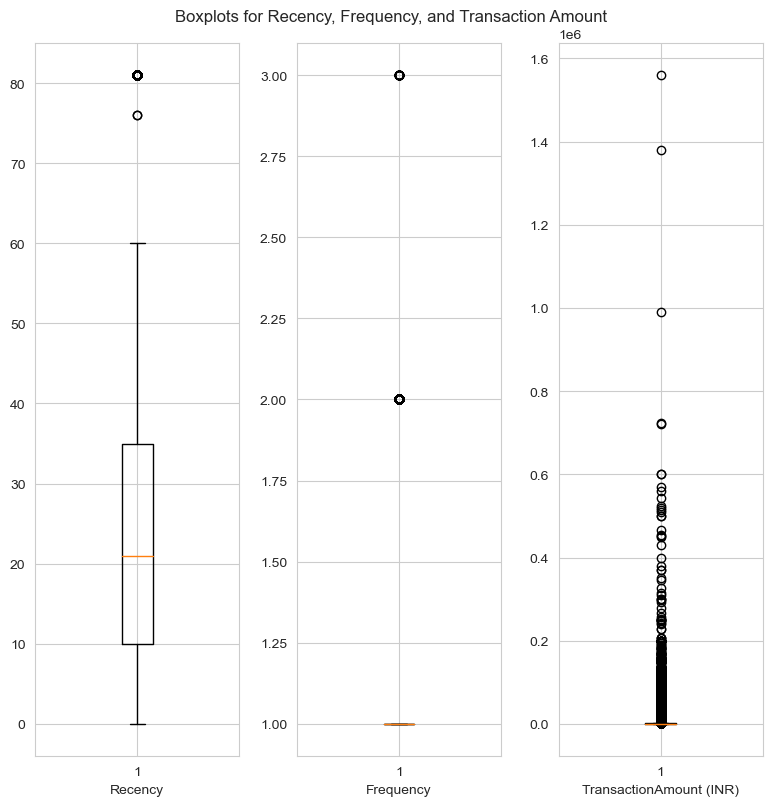

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8))
fig.suptitle('Boxplots for Recency, Frequency, and Transaction Amount')
fig.tight_layout()
ax1.boxplot(x=finaldf['Recency'])
ax1.set_xlabel('Recency')
ax2.boxplot(x=finaldf['Frequency'])
ax2.set_xlabel('Frequency')
ax3.boxplot(x=finaldf['TransactionAmount (INR)'])
ax3.set_xlabel('TransactionAmount (INR)');

## Removing Outliers

In [54]:
new_df = finaldf[['Recency','Frequency','TransactionAmount (INR)']]
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [55]:
new_df.head()

,Recency,Frequency,TransactionAmount (INR)
0,8,1,356.0
1,13,1,1499.0
2,0,1,1205.0
3,45,1,30.0
4,17,1,5000.0


## Clustering

In [56]:
new_df = new_df.drop_duplicates()
col_names = ['Recency','Frequency','TransactionAmount (INR)']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Recency,Frequency,TransactionAmount (INR)
0,-1.020457,0.0,-0.633509
1,-0.688984,0.0,-0.240614
2,-1.550813,0.0,-0.341674
3,1.432440,0.0,-0.745568
4,-0.423806,0.0,0.962820


## Creating and Fitting Kmeans Model

100%|██████████| 9/9 [00:42<00:00,  4.76s/it]


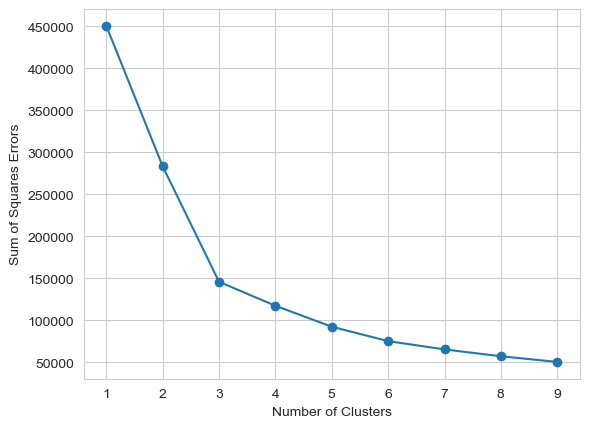

In [57]:
SSE = []
for k in tqdm(range(1,10)):
    model = KMeans(n_clusters = k, init='k-means++')
    model.fit(scaled_features)
    SSE.append(model.inertia_)

plt.plot(range(1,10), SSE, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Errors');

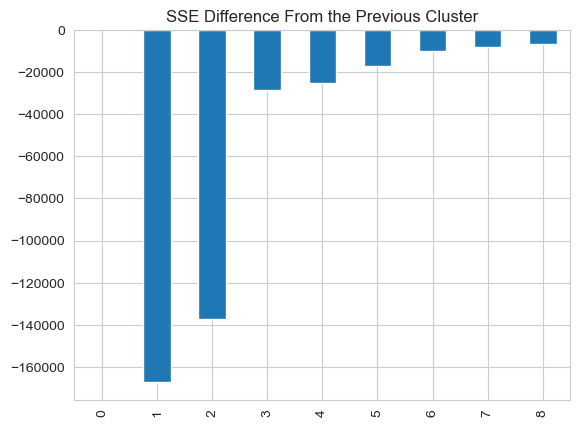

In [58]:
pd.Series(SSE).diff().plot(kind='bar', title='SSE Difference From the Previous Cluster');

In [59]:
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [60]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.49258634484858965


In [61]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred
frame.head()

,Recency,Frequency,TransactionAmount (INR),cluster
0,8,1,356.0,1
1,13,1,1499.0,1
2,0,1,1205.0,1
3,45,1,30.0,0
4,17,1,5000.0,1


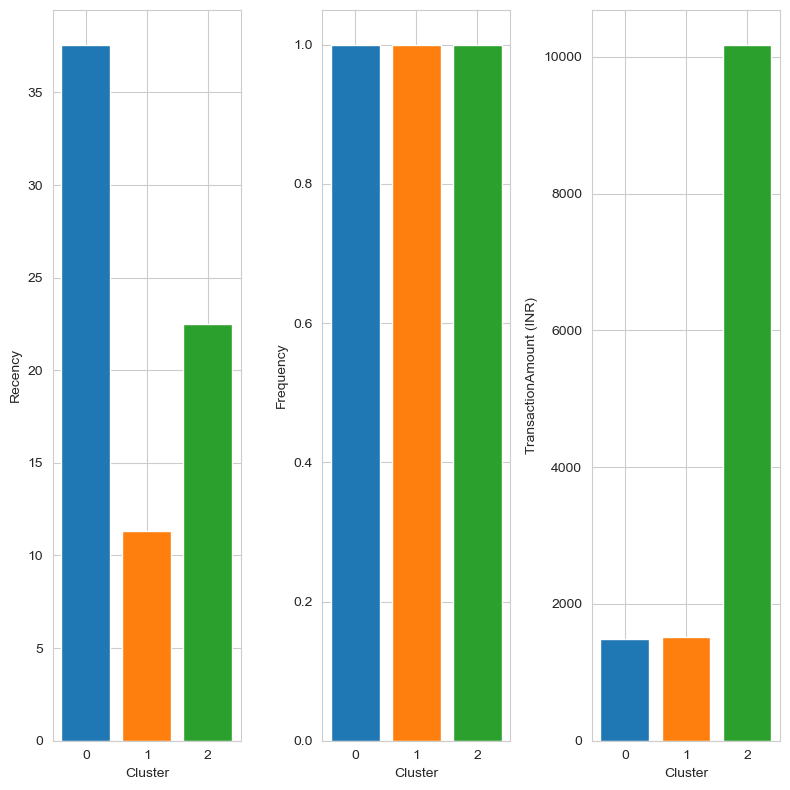

In [62]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8))
ax1.bar(x=avg_df['cluster'],height=avg_df['Recency'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Recency')
ax2.bar(x=avg_df['cluster'],height=avg_df['Frequency'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Frequency')
ax3.bar(x=avg_df['cluster'],height=avg_df['TransactionAmount (INR)'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax3.set_xlabel('Cluster')
ax3.set_ylabel('TransactionAmount (INR)')
fig.tight_layout();

| Cluster | Customer Atributes | 
|:--------:|:--------:|
|  0   |  Customers in this cluster have high recency and frequency, and low transaction amount scores. These are people who frequently make small transactions.   |
|  1   |  Customers in this cluster have low recency, high frequency, and low transaction amount scores. These are people who frequently make small transactions. However, the transactions made from these customers were made earlier compared to the transactions made from customers in the other clusters.   |
|  2   |  Customers in this cluster have high recency, frequency, and transaction amount scores. These are people who frequently make large transactions.   |